# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane-line Finding** 
***


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Prepare Helper functions


In [2]:
class Camera:
    chessboard_size = (9,6)
    
    def __init__(self):
        # Store camera calibration
        self.calibrated = self.calibrate_camera()
        
    def is_calibrated(self): 
        return self.calibrated
    
    def calibrate_camera(self, save_img=False):
        # See https://www.youtube.com/watch?v=lA-I22LtvD4
        # Loop over all calibration images in 'camera_cal' folder using glob
        # 1) Convert to grayscale
        # 2) Find chessboardCorners
        # 3) If found, append objp and found corner image points to objpoints and imgpoints lists
        
        # Get all calibration image paths
        paths = glob.glob("camera_cal/calibration*.jpg")
        
        # Collect all cal images' objpoints and corresponding imgpoints in 2 lists
        objpoints = []
        imgpoints = []
        
        # Prepare obj points of corners like (0, 0, 0), (1, 0, 0), ... (8,5,0) - chessboard is 9x6
        objp = np.zeros((9*6, 3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # x,y coords
        
        for path in paths:
            # Read in image
            image = mpimg.imread(path)
            
            # Get grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Find chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, self.chessboard_size, None)
            
            if ret:
                # Found corners, append to correspondence arrays
                objpoints.append(objp)
                imgpoints.append(corners)
                
                # Draw and display corners on image
                if save_img:
                    image = cv2.drawChessboardCorners(image, self.chessboard_size, corners, ret)
                    plt.imshow(image)
                    out_filename = "camera_cal_output/" + path.split("/")[-1]
                    cv2.imwrite(out_filename, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        
        # Lastly, save the calibration parameters for image undistortion
        _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        self._calibration = (mtx, dist, None, mtx)
        return True

    def undistort(self, img):
        # Raises exception if camera not yet calibrated
        if not self.calibrated:
            raise Exception("Camera not calibrated")
        else:
            return cv2.undistort(img, *self._calibration)

## Test calibration and distortion correction

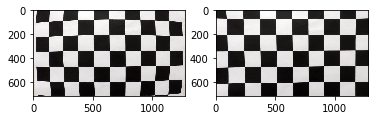

In [3]:
cam = Camera()
cam.calibrate_camera(save_img=True)

example = mpimg.imread("camera_cal/calibration1.jpg")
undistort = cam.undistort(example)

plt.subplot(1,2,1)
plt.imshow(example)
plt.subplot(1,2,2)
plt.imshow(undistort)
plt.imsave("camera_cal_output/example_undistort.jpg", undistort)

## Selecting the perspective transform
Chose src points along a straight lane from an example undistorted image. The dst points
should be such that the quadrilateral selected by src points becomes a rectangle making up the destination warped image.

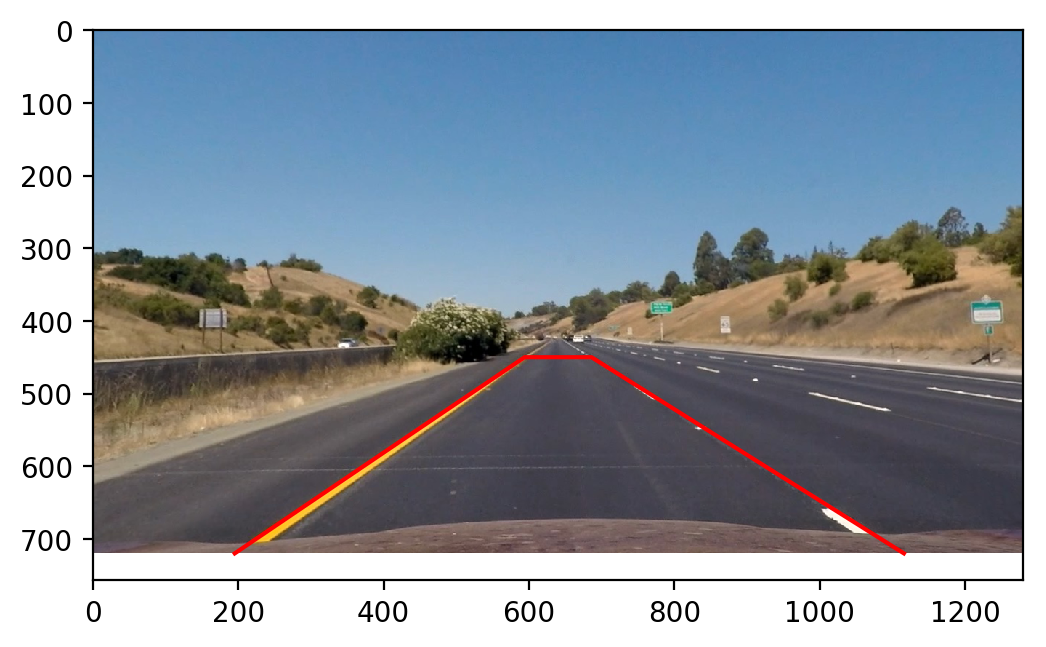

In [4]:
%matplotlib inline
dist_image = mpimg.imread("test_images/straight_lines1.jpg")
cam = Camera()
image = cam.undistort(dist_image)
plt.imsave("output_images/straight_lines1-undistort.jpg", image)
plt.rcParams['figure.dpi'] = 200
plt.imshow(image)
# Choosing src points along straight lane (as close to center of image as possible to min. distortion)
src = np.float32([  [195, image.shape[0]],
                   [594, 450],
                   [686, 450],
                   [1116, image.shape[0]]
])
plt.plot(src[:,0], src[:,1], 'red')
plt.savefig("output_images/straight_lines1-perspective.jpg")

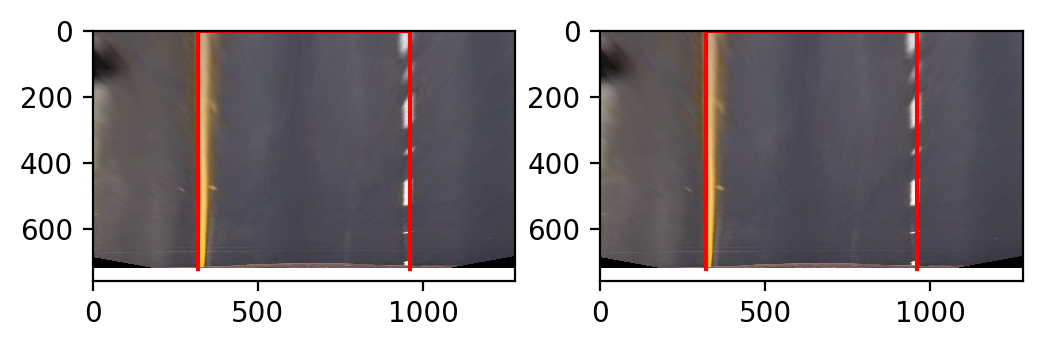

In [5]:
# Dst points
dst = np.float32([ [image.shape[1]/4, image.shape[0]],
                 [image.shape[1]/4, 0],
                 [(image.shape[1]*3)//4, 0],
                 [(image.shape[1]*3)//4, image.shape[0]]
])
m = cv2.getPerspectiveTransform(src, dst)
shape = (image.shape[1], image.shape[0])
plt.subplot(1,2,1)
warped = cv2.warpPerspective(image, m, shape, flags=cv2.INTER_LINEAR)
plt.imshow(warped)
plt.plot(dst[:,0], dst[:,1], 'red')
plt.subplot(1,2,2)
# "Area" interpolation is supposed to be the best, but is slow. Linear is faster and a good approximation
warped = cv2.warpPerspective(image, m, shape, flags=cv2.INTER_AREA)
plt.imshow(warped)
plt.plot(dst[:,0], dst[:,1], 'red')

plt.savefig("output_images/warped-compare-area-linear-interpolation.jpg")

We notice that uncorrected camera distortion may contribute to the curvature at the lower base of the lane lines. This 
could be expected because camera distortion is stronger at the outer edges of an image, and camera calibration
may not have been able to perfectly estimate the distortion coefficients.

## Below we prepare a class for Perspective operations
Note, we use linear interpolation of pixels when warping images in order to preserve pixel contrast while not sacrificing computation speed.
This is useful to ensure more pixels are selected from the lane lines which will ensure more accurate fits.

In [6]:
class PerspectiveTransform:
    # Use hard-coded src and dst points for perspective transform
    dst = np.float32([[ 320.,  720.],
                      [ 320.,    0.],
                      [ 960.,    0.],
                      [ 960.,  720.]])
    src = np.float32([[  195.,   720.],
                      [  594.,   450.],
                      [  686.,   450.],
                      [ 1116.,   720.]])
    def __init__(self):
        self._mtx2bev = cv2.getPerspectiveTransform(src, dst)
        self._mtx2car = cv2.getPerspectiveTransform(dst, src)
        
    def highway_birds_eye_view(self, highway_image):
        out_shape = highway_image.shape[1::-1]
        return cv2.warpPerspective(highway_image, self._mtx2bev, out_shape, flags=cv2.INTER_LINEAR)
    
    def car_view(self, birds_eye_view_img):
        out_shape = birds_eye_view_img.shape[1::-1]
        return cv2.warpPerspective(birds_eye_view_img, self._mtx2car, out_shape, flags=cv2.INTER_LINEAR)

## Thresholded binary image

In [7]:
def img2linebinary(img, s_thresh=(150, 250), sx_thresh=(50,250)):
    img = np.copy(img)
    # Convert to HLS color space and separate the Saturation channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Sobel in x-axis to accentuate vertical edges
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)

    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary, s_binary, sxbinary
    

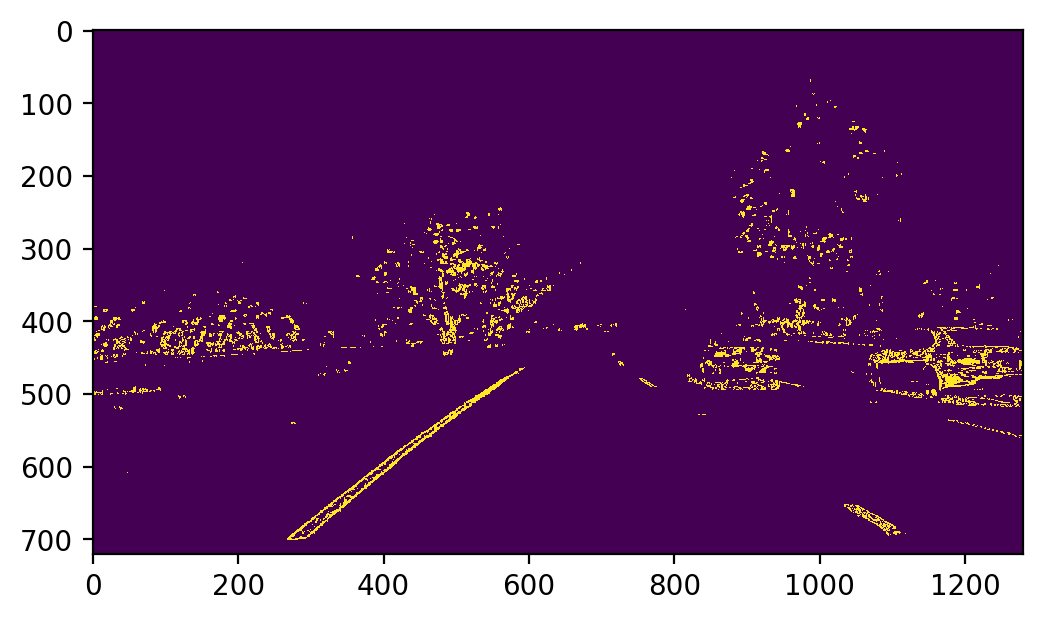

In [8]:
o_img = mpimg.imread("test_images/test1.jpg") 
camera = Camera()
persp = PerspectiveTransform()

# Undistort o_img
undist = camera.undistort(o_img)

# Threshold first then warp to birds-eye-view
undist_bin, s_binary, sx_binary = img2linebinary(undist)
bev_bin = persp.highway_birds_eye_view(undist_bin)
plt.imshow(undist_bin)
plt.savefig("output_images/test1-thresholded.jpg")

# Lane Detection

## Test histogram+sliding window search for lane-line pixels

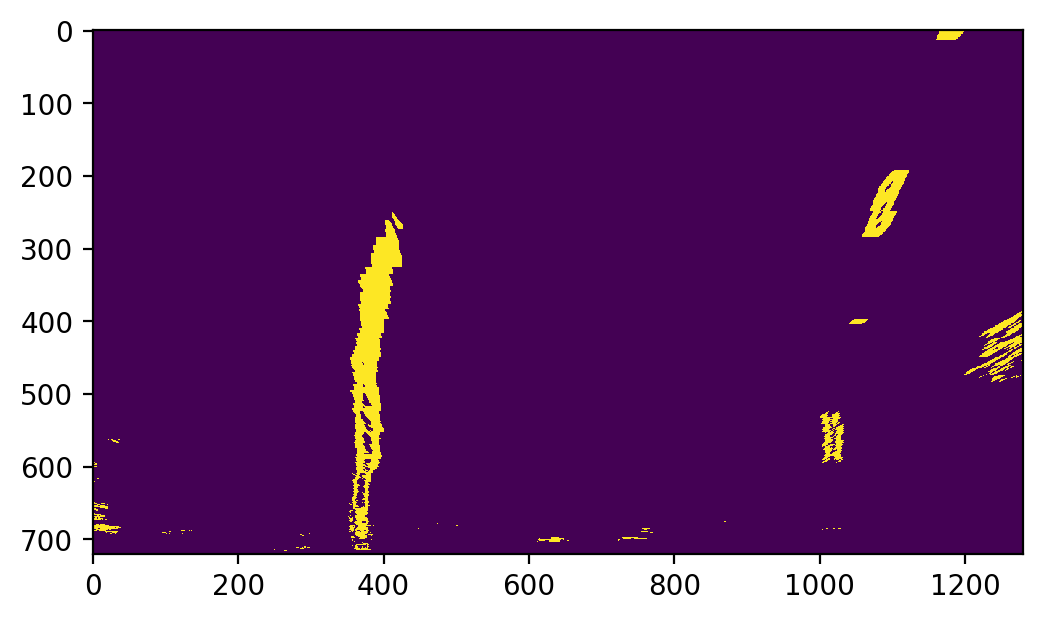

In [9]:
o_img = mpimg.imread("test_images/test4.jpg") 
camera = Camera()
persp = PerspectiveTransform()

# Undistort o_img
undist = camera.undistort(o_img)
# Threshold first then warp to birds-eye-view
undist_bin, _, _ = img2linebinary(undist)
bev_bin = persp.highway_birds_eye_view(undist_bin)
plt.imshow(bev_bin)

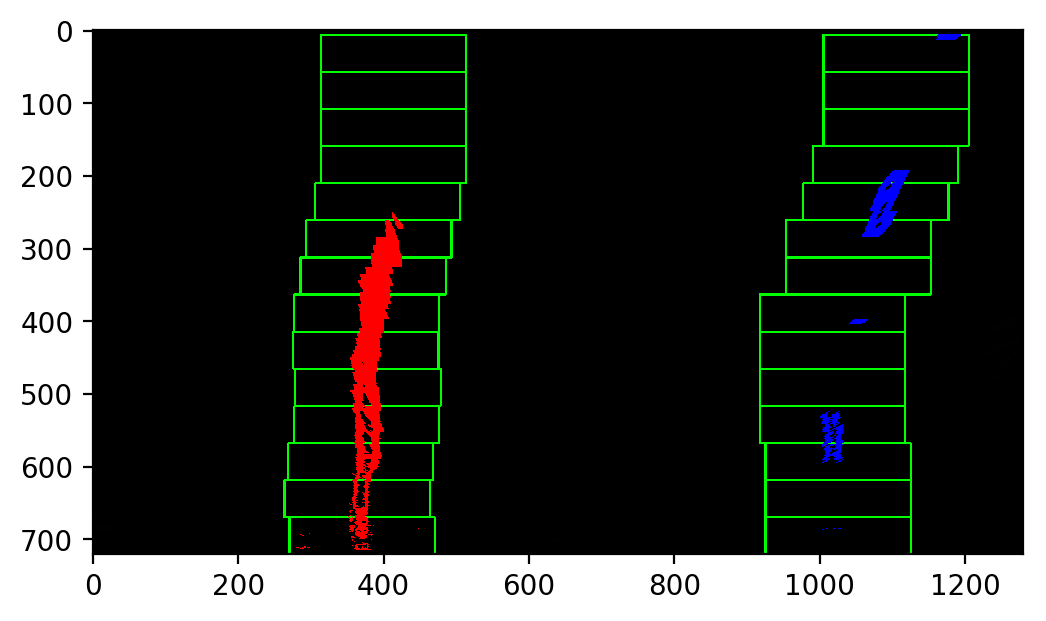

In [10]:
# Modified from "Sliding Window" quiz
def find_lane_pixels_histogram_window(binary_warped,
                                      nwindows=14,
                                      margin=100,
                                      minpix=25):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Append these indices to the lists
        if good_left_inds.size:
            left_lane_inds.append(good_left_inds)
        if good_right_inds.size:
            right_lane_inds.append(good_right_inds)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return leftx, lefty, rightx, righty, out_img
leftx, lefty, rightx, righty, out_img = find_lane_pixels_histogram_window(bev_bin)
plt.imshow(out_img)

plt.savefig("output_images/test1-windowed")

## Next, define Line class to make tracking of line state between frames easier

In [11]:
class Line:
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    MAX_REAL_LANE_WIDTH_M = 4 # meters (~12 ft)
    # see https://safety.fhwa.dot.gov/geometric/pubs/mitigationstrategies/chapter3/3_lanewidth.cfm
    MIN_REAL_CURVATURE_M = 150 # meters (~500 ft.)
    # see http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC
    THRESH_TURN_RADIUS = 4e3 # meters ("turns" are under 4km radius)
    
    def __init__(self, n=10, reject_max=4):
        # determine n
        self.n = n
        # Save last n coeffs to average over
        self.last_n_fits = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # Store fit pixels for most recent fit
        self.curr_fitx = None
        self.curr_fity = None
        #x values for last detected line pixels
        self._allx = None
        #y values for last detected line pixels
        self._ally = None
        
        # Reset flag begins as set
        self.reset_flag = True
        self.reject_count = 0
        self.reject_max = reject_max
    
    @classmethod
    def convert_coeffs_to_real(cls, coeffs):
        # using x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
        return np.array([coeffs[0] * (cls.xm_per_pix/(cls.ym_per_pix**2)),
                           coeffs[1] * (cls.xm_per_pix/cls.ym_per_pix),
                           coeffs[2]])
    @staticmethod
    def eval_poly_at(y_eval, coeffs):
        return coeffs[0]*y_eval**2 + coeffs[1]*y_eval + coeffs[2]
    
        
    @staticmethod
    def fit_poly_to_points(img_shape, lane_x, lane_y):
        '''
        Takes image shape, corresponding x points for this lane, corresponding y points for this lane
        '''
        fit = np.polyfit(lane_y, lane_x, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        fitx = None
        try:
            fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        except TypeError:
            # Avoids an error if `fit` is still none or incorrect
            print('The function failed to fit a line!')
        return fit, fitx, ploty
    
    @staticmethod
    def sanity_check_lane_lines(img_shape, left_fit, right_fit, 
                                prl_tol_px = 100,
                                real_crv_tol_m = 10,
                                width_tol_m = 5):
        '''
        Returns whether two lines have:
        - real curvature is reasonable (i.e. above minimum real curvature)
        - approximately are of reasonable width (at bottom of image)
        - AND are roughly parallel (checked at bottom and top of image)
        '''
        # compare real curvatures
        y_eval = img_shape[0]
        left_fit_r = Line.convert_coeffs_to_real(left_fit)
        right_fit_r = Line.convert_coeffs_to_real(right_fit)
        left_crv = Line.compute_curvature(y_eval, left_fit_r)
        right_crv = Line.compute_curvature(y_eval, right_fit_r)
        
        # Check that real curvatures are reasonable
        if left_crv < (Line.MIN_REAL_CURVATURE_M + real_crv_tol_m) \
or right_crv < (Line.MIN_REAL_CURVATURE_M + real_crv_tol_m):
            print ("Sanity failure: Curvature below official minimum:", left_crv, right_crv)
            return False
        
        # Check if real distance between lines at bottom of image is reasonable
        bot_left_x = Line.eval_poly_at(img_shape[0], left_fit)
        bot_right_x = Line.eval_poly_at(img_shape[0], right_fit)
        bot_dist = np.abs(bot_right_x - bot_left_x)
        if np.abs(bot_dist * Line.xm_per_pix) > (Line.MAX_REAL_LANE_WIDTH_M + width_tol_m):
            print ("Sanity failure: estimated real lane width above threshold:", np.abs(bot_dist * Line.xm_per_pix))
            return False

        # Check if lines parallel (similar distances between at top and bottom of image)
        top_left_x = Line.eval_poly_at(0, left_fit)
        top_right_x = Line.eval_poly_at(0, right_fit)
        top_dist = np.abs(top_right_x - top_left_x)
        if np.abs(bot_dist - top_dist) > prl_tol_px:
            print ("Sanity failure: lines not roughly parallel. (bot-top) difference:", np.abs(bot_dist - top_dist))
            print("Curvatures", bot_dist, top_dist)
            return False
        
        return True
    
    def requires_new_prior(self):
        '''
        Returns whether this line requires next frame to be searched fully (i.e. with sliding window)
        - Dependent upon whether Line is initialized or whether reset_count is above threshold
        '''
        return self.reset_flag

    def save_new_fit_and_points(self, fit_coeffs, fitx, fity, line_x, line_y):
        # First, unset reset_flag and zero rejection count
        self.reset_flag = False
        self.reject_frame_count = 0
        
        # Save fit points
        self.curr_fitx = fitx
        self.curr_fity = fity
        
        # Save points for computing current real radius of curvature
        self._allx = line_x
        self._ally = line_y
        
        # Save and append latest fit to last_n_fits
        self.current_fit = fit_coeffs
        self.last_n_fits.append(fit_coeffs)
        if len(self.last_n_fits) > self.n:
            del self.last_n_fits[0]
        
        # Update best fit
        self.best_fit = np.mean(np.array(self.last_n_fits), axis=0)
        return 
    
    def reject_frame(self):
        '''
        Signals to set reset_flag if number of consecutive rejected frames is above threshold
        '''
        self.reject_count += 1
        if self.reject_count > self.reject_max:
            print("Prepared to reset!")
            self.reset_flag = True
        return
            
    def compute_best_real_curvature(self, img_shape):
        '''
        Calculates the curvature of polynomial function in meters using bestfit (smoothed fit over n)
        Returns None if no fits available
        '''
        if len(self.last_n_fits):
            # Define y-value where we want radius of curvature
            # We'll choose the maximum y-value, corresponding to the bottom of the image
            y_eval = img_shape[0]*self.ym_per_pix

            # Scale bestfit polynomial to real-world coordinates from pixel space
            bestfit_cr = Line.convert_coeffs_to_real(self.best_fit)

            # Compute radius of curvature
            return Line.compute_curvature(y_eval, bestfit_cr)
        else:
            return None
    
    def compute_curr_real_curvature(self):
        '''
        Calculates curvature of polynomail function in pixels using latest fit
        '''
        y_eval = np.max(self._ally)
        return Line.compute_curvature(y_eval, self.current_fit)
    
    @staticmethod
    def compute_curvature(y_eval, coeffs):
        return ((1+(2*coeffs[0]*y_eval + coeffs[1])**2)**(3/2))/(2*np.abs(coeffs[0]))
    
    @classmethod
    def compute_vehicle_lane_offset(cls, left_line, right_line, img_shape):
        '''
        Takes 2 Line objects as input and the shape of the undistorted highway image
        Assuming center of the undistorted image corresponds to the location of the car between lines:
        Returns real distance (in m) of vehicle from center of lane, None if no fits available
        '''
        if len(left_line.last_n_fits) and len(right_line.last_n_fits):
            car_x = int(round(img_shape[1]/2))
            y_img_bot = img_shape[0]
            left_bot_x = Line.eval_poly_at(y_img_bot, left_line.best_fit)
            right_bot_x = Line.eval_poly_at(y_img_bot, right_line.best_fit)

            # Find lane center and car offset
            lane_center_x = (right_bot_x + left_bot_x) / 2
            lane_offset_px = lane_center_x - car_x

            return lane_offset_px * cls.xm_per_pix
        else:
            return None       

## Next, test fitting of polynomial using Line objects

In [12]:
bin_img = bev_bin
left_fit, left_fitx, left_fity = Line.fit_poly_to_points(bin_img.shape, leftx, lefty)
right_fit, right_fitx, right_fity = Line.fit_poly_to_points(bin_img.shape, rightx, righty)

# Save polynomials into respective Line objects
left_line = Line()
left_line.save_new_fit_and_points(left_fit, left_fitx, left_fity, leftx, lefty)
right_line = Line()
right_line.save_new_fit_and_points(right_fit, right_fitx, right_fity, rightx, righty)

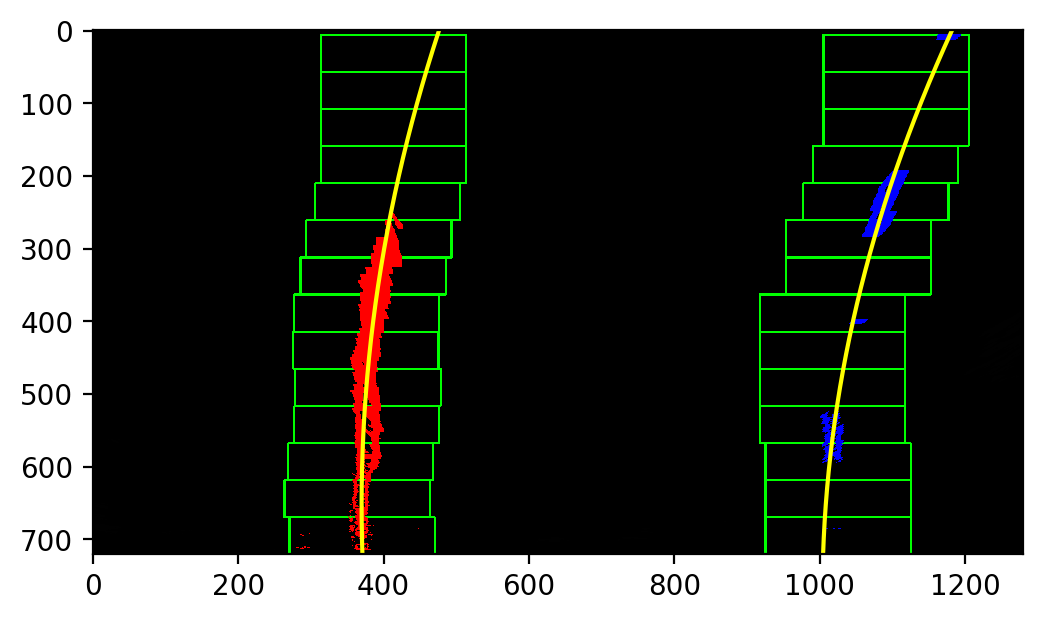

In [13]:
# Generate x and y values for plotting
plt.plot(left_fitx, left_fity, color='yellow')
plt.plot(right_fitx, right_fity, color='yellow')
plt.imshow(out_img)

plt.savefig("output_images/test1-windowed-polyfit.jpg")

This looks good, next we'll try searching from an existing polynomial. 
test1.jpg appears to come after test4.jpg along the highway, which makes it a valid frame to search for 
lane line pixels using a prior fit.

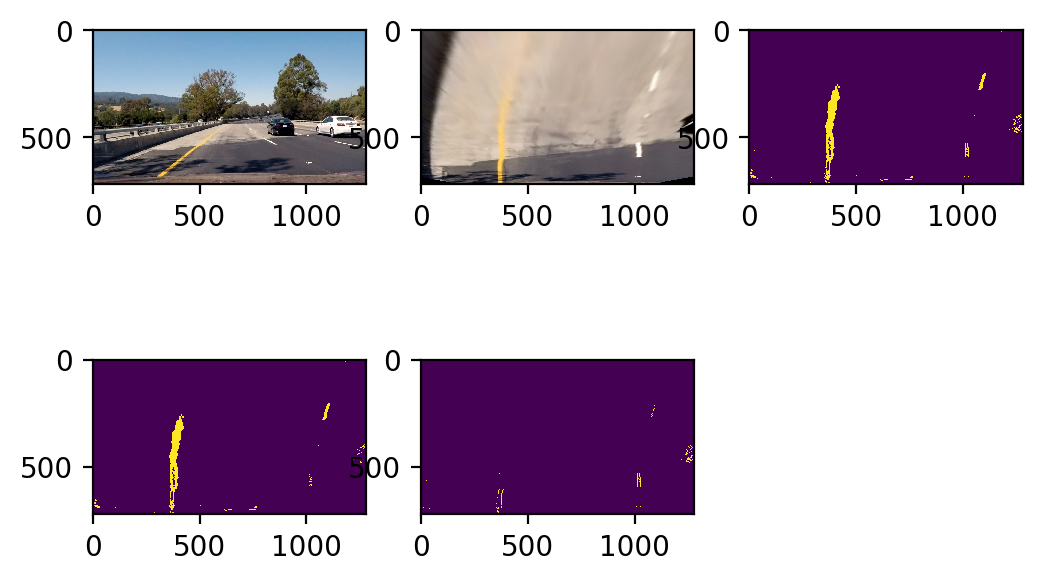

In [14]:
o_img = mpimg.imread("test_images/test4.jpg") 

# Undistort o_img
undist = camera.undistort(o_img)

# Get birds-eye-view of highway image
bev = persp.highway_birds_eye_view(undist)

# Convert bev image to thresholded binary image
bev_bin, s_binary, sx_binary = img2linebinary(bev)

plt.subplot(2,3,1)
plt.imshow(o_img)
plt.subplot(2,3,2)
plt.imshow(bev)
plt.subplot(2,3,3)
plt.imshow(bev_bin)

plt.subplot(2,3,4)
plt.imshow(s_binary)
plt.subplot(2,3,5)
plt.imshow(sx_binary)

In [15]:
# Modified From "Search from Prior" quiz
def find_lane_pixels_from_prior(binary_warped, left_line, right_line, margin = 100):
    # Extract best fit from line objects (MUST BE non-None)
    assert(left_line.best_fit is not None and right_line.best_fit is not None)
    left_fit = left_line.best_fit
    right_fit = right_line.best_fit

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Search within margin surrounding existing fit lines
    ploty = nonzeroy
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_min, left_max = leftx - margin, leftx + margin
    right_min, right_max = rightx - margin, rightx + margin
    left_lane_inds = ((nonzerox < left_max) & (nonzerox > left_min))
    right_lane_inds = ((nonzerox < right_max) & (nonzerox > right_min))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img

# test4.jpg appears to precede test1.jpg, so this is a valid frame to process with a prior fit
leftx, lefty, rightx, righty, out_img = find_lane_pixels_from_prior(bev_bin, left_line, right_line)

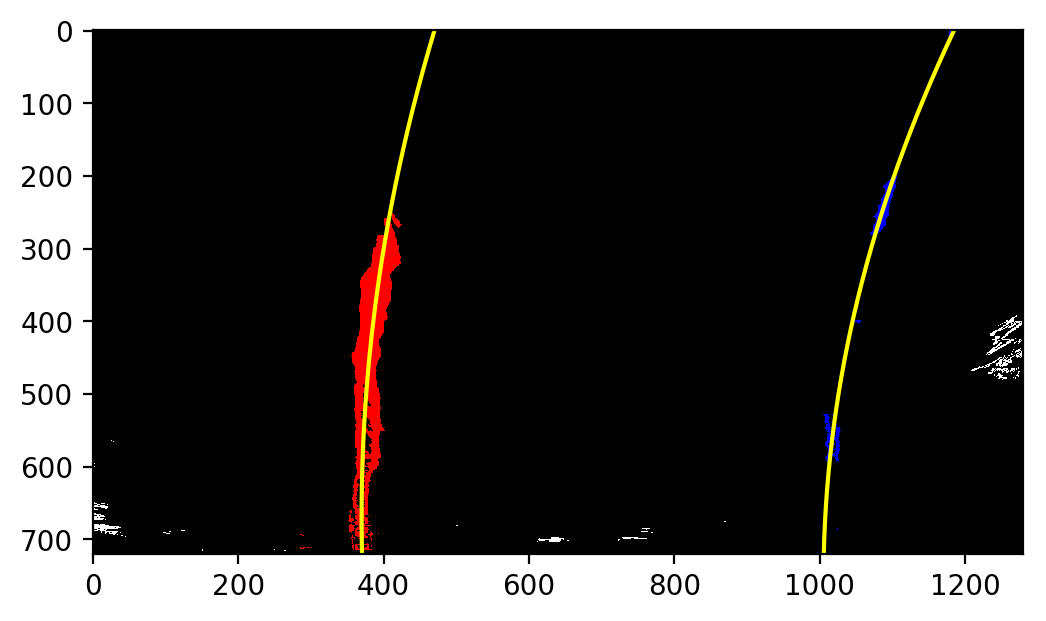

In [16]:
left_fit, left_fitx, left_fity = Line.fit_poly_to_points(bev_bin.shape, leftx, lefty)
right_fit, right_fitx, right_fity = Line.fit_poly_to_points(bev_bin.shape, rightx, righty)

# Generate x and y values for plotting
plt.plot(left_fitx, left_fity, color='yellow')
plt.plot(right_fitx, right_fity, color='yellow')
plt.imshow(out_img)

plt.savefig("output_images/test4-fit-search-prior.jpg")

## We can now turn lane line detection from thresholded image into a pipeline function
First, determine whether we need to search using windows or simply from prior estimate using line object state.
Second, select pixels with this chosen method. 
Third, fit a polynomial to these pixels with x as a function of y.
Lastly, determine whether the fits are valid/sane (realistic curvature, realistic lane width, lines roughly parallel)
If not valid, don't consume frame or selected pixels and add to skipped frame count for both Line objects. Several consecutive skipped frames will trigger a holistic/windowed search to 'reset' the lines' prior estimates.
Else, accept the frame and next valid fit - each lane line's best fit is also updated (as a smoothed fit from last n fit coefficients).

In [17]:
def detect_lane_lines(bin_img, left_line, right_line):
    '''
    Take in binary thresholded image, previous estimates of left and right lines (if detected)
    Return tuple (found, new_left_line, new_right_line)
    '''
    
    '''
    If no existing estimate of lines (first frame) or line estimates triggered to reset, then
    use histogram + sliding window to find lane line pixels. 
    Else, select only the pixels within a margin from prev lines' fit
    '''
    try:
        if left_line.requires_new_prior() or right_line.requires_new_prior():
            leftx, lefty, rightx, righty, out_img = find_lane_pixels_histogram_window(bin_img)
        else:
            leftx, lefty, rightx, righty, out_img = find_lane_pixels_from_prior(bin_img, left_line, right_line)

        '''
        After selecting line pixels, fit lines to new sets of line pixels.
        '''
        left_fit_cand, left_fitx, left_fity = Line.fit_poly_to_points(bin_img.shape, leftx, lefty)
        right_fit_cand, right_fitx, right_fity = Line.fit_poly_to_points(bin_img.shape, rightx, righty)

        '''
        Lane line sanity checks:
        - realistic curvature
        - separated by approximately the right distance horizontally
        - are roughly parallel (similar magnitudes of first and second fit parameters)
        If lines detected don't pass checks, reject these lines (found=False). Else, accept this frame
        '''
        found = None
        if Line.sanity_check_lane_lines(bin_img.shape, left_fit_cand, right_fit_cand):
            # Accept this frame
            found = True
            left_line.save_new_fit_and_points(left_fit_cand, left_fitx, left_fity, leftx, lefty)
            right_line.save_new_fit_and_points(right_fit_cand, right_fitx, right_fity, rightx, righty)
        else:
            # Reject this frame
            found = False
            left_line.reject_frame()
            right_line.reject_frame()
        
        return found, left_line, right_line
    except Exception as e:
        print("Caught exception! Skipping bad frame due to: " + str(e))
        left_line.reject_frame()
        right_line.reject_frame()
        found = False

        return found, left_line, right_line
        

## Fine-tuning thresholding for lighter asphalt in test images
Will use these parameters for all images: s_thresh=(150, 255), sx_thresh=(30,250)

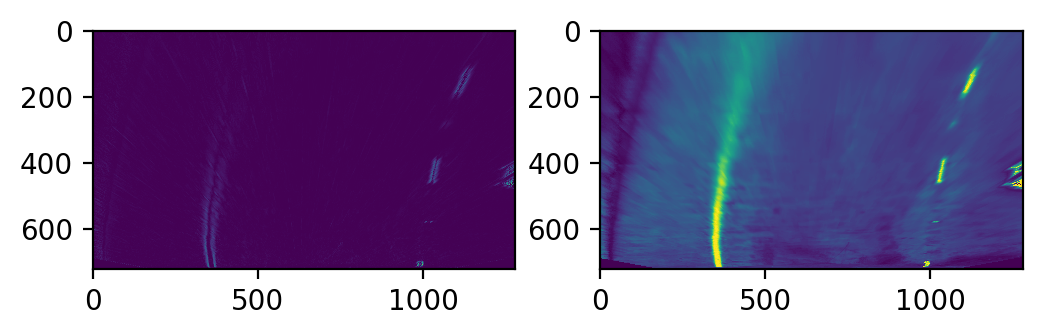

In [18]:
o_img = mpimg.imread("test_images/test1.jpg") 

# Undistort o_img
undist = camera.undistort(o_img)

# Get birds-eye-view of highway image
bev = persp.highway_birds_eye_view(undist)

# Convert bev image to thresholded binary image
img = np.copy(bev)
# Convert to HLS color space and separate the Saturation channel
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
# Sobel in x-axis to accentuate vertical edges
sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx)

scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
plt.subplot(1,2,1)
plt.imshow(scaled_sobel)
plt.subplot(1,2,2)
plt.imshow(s_channel)

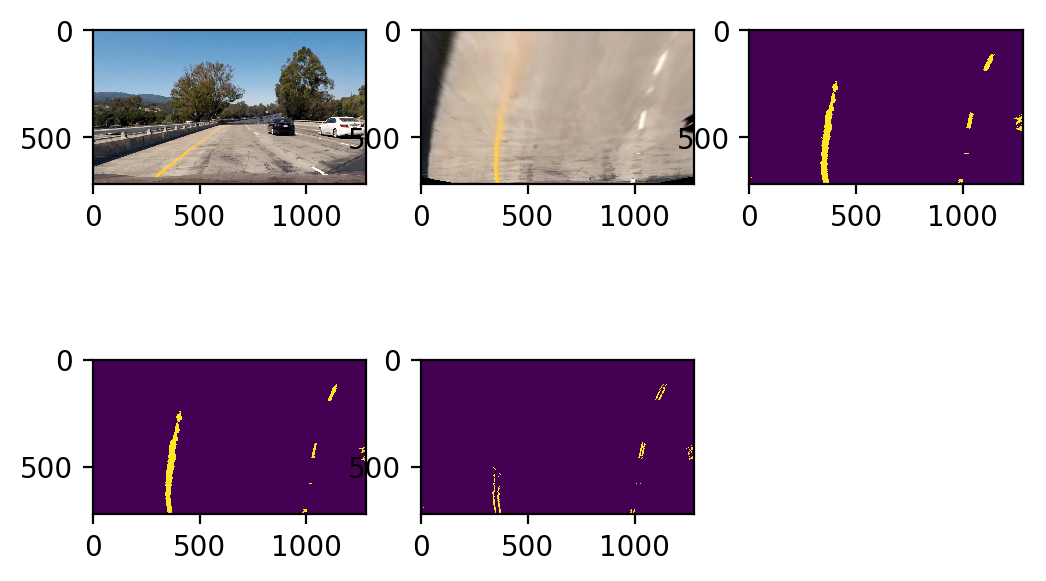

In [19]:
bev_bin, s_binary, sx_binary = img2linebinary(bev, s_thresh=(150, 255), sx_thresh=(30,250))

plt.subplot(2,3,1)
plt.imshow(o_img)
plt.subplot(2,3,2)
plt.imshow(bev)
plt.subplot(2,3,3)
plt.imshow(bev_bin)

plt.subplot(2,3,4)
plt.imshow(s_binary)
plt.subplot(2,3,5)
plt.imshow(sx_binary)

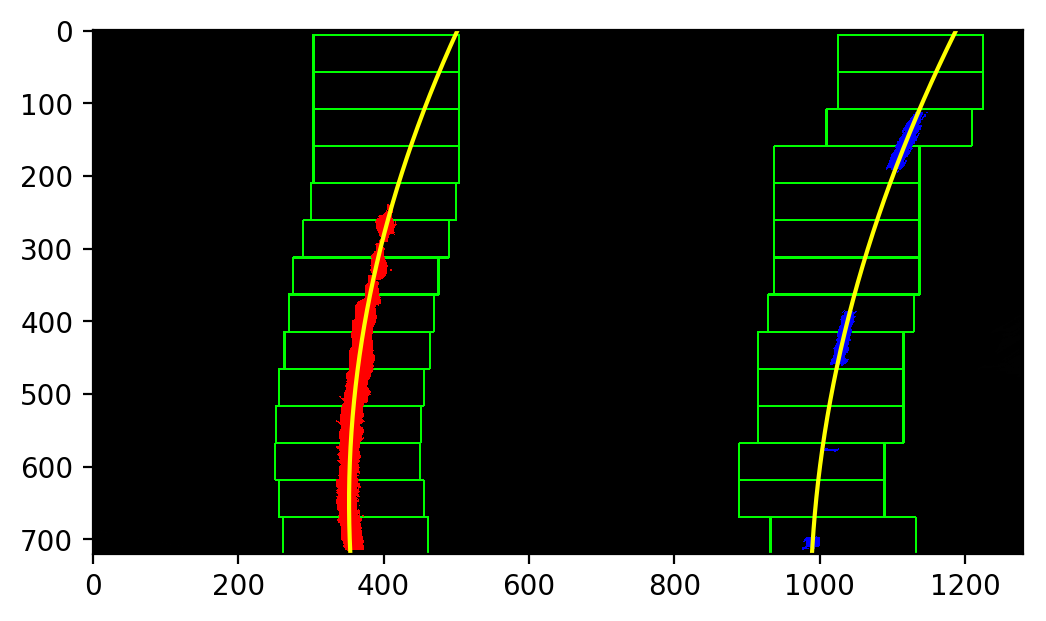

In [20]:
leftx, lefty, rightx, righty, out_img = find_lane_pixels_histogram_window(bev_bin)
plt.imshow(out_img)
left_fit, left_fitx, left_fity = Line.fit_poly_to_points(bin_img.shape, leftx, lefty)
right_fit, right_fitx, right_fity = Line.fit_poly_to_points(bin_img.shape, rightx, righty)

# Generate x and y values for plotting
plt.plot(left_fitx, left_fity, color='yellow')
plt.plot(right_fitx, right_fity, color='yellow')
plt.imshow(out_img)

## Build a Lane Finding Pipeline

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify undistorted image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [21]:
'''
Takes camera obj, perspective obj, original image, left Line obj, right Line obj as input
returns image with detected lane, lane curvature, and vehicle offset overlaid onto the image
'''
if not camera.is_calibrated():
    # Compute camera calibration if not done already
    camera.calibrate_camera()

o_img = mpimg.imread("test_images/test1.jpg") 
    
# Undistort o_img
undist = camera.undistort(o_img)

# Get birds-eye-view of highway image
bev = persp.highway_birds_eye_view(undist)

# Convert bev image to thresholded binary image
bev_bin, _, _ = img2linebinary(bev)

# Detect lines in this frame
left_line = Line() # reset
right_line = Line() # reset
found, left_line, right_line = detect_lane_lines(bev_bin, left_line, right_line)
if not found:
    # Lane could not be detected in this frame, overlay previous lanes onto this image
    print("Failed to detect lane in this frame, falling back to prev frame's lane estimate")

# Determine real-world curvature of lanes (avg. of both lines' real curvature)
lane_curvature = (left_line.compute_best_real_curvature(bev.shape) + right_line.compute_best_real_curvature(bev.shape))/2
print("Average curvature (m):", lane_curvature)

# Determine vehicle offset of center between lane line estimates (round to 3 decimal points)
veh_offset = Line.compute_vehicle_lane_offset(left_line, right_line, bev.shape)
print("Vehicle offset (m):", veh_offset)

Average curvature (m): 510.750492087
Vehicle offset (m): 0.167114894838


## Finally, we include visualization for the lane area and lane characteristics

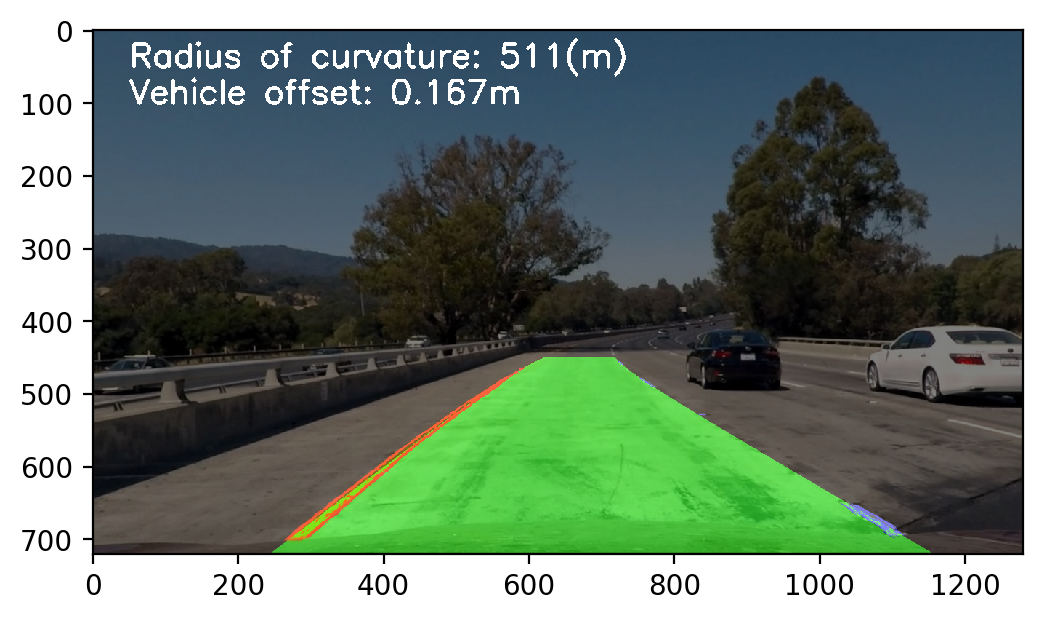

In [22]:
def overlay_visualization(bev_bin, found, undist, persp, left_line, right_line, lane_curvature_s, veh_offset_s):
    ## Modified from provided visualization code for project
    # Create an image to draw the lines on
    bev_zero = np.zeros_like(bev_bin).astype(np.uint8)
    color_warp = np.dstack((bev_zero, bev_zero, bev_zero))

    # If lane lines are initialized, draw estimated lane area
    if len(left_line.last_n_fits) and len(right_line.last_n_fits):
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.curr_fitx, left_line.curr_fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.curr_fitx, right_line.curr_fity])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Next, if the lane pixels were found, draw them
    if found:
        leftx = np.int_(left_line._allx)
        lefty = np.int_(left_line._ally)
        rightx = np.int_(right_line._allx)
        righty = np.int_(right_line._ally)
        color_warp[lefty, leftx] = (255,0,0)
        color_warp[righty, rightx] = (0,0,255)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = persp.car_view(color_warp)
    # Combine the result with the original image
    lane_area = cv2.addWeighted(undist, .5, newwarp, 0.5, 0)

    # Draw curvature and vehicle offset at top of image
    crv_org = (50,50)
    off_org = (50,100)
    fontScale = 1.5
    text_color = (255,255,255)
    thickness = 3
    crv_string = "Radius of curvature: %s" % lane_curvature_s
    cv2.putText(lane_area, crv_string,
                crv_org, cv2.FONT_HERSHEY_SIMPLEX, fontScale, text_color, thickness)
    # Now draw offset text
    offset_string = "Vehicle offset: %s" % veh_offset_s
    cv2.putText(lane_area, offset_string,
                off_org, cv2.FONT_HERSHEY_SIMPLEX, fontScale, text_color, thickness)
    return lane_area, newwarp

lane_curvature_s = "%d(m)" % int(round(lane_curvature))
veh_offset_s = "%0.3fm" % veh_offset
lane_area, newwarp = overlay_visualization(bev_bin, found, undist, persp, left_line, right_line, lane_curvature_s, veh_offset_s)
plt.imshow(lane_area)

plt.savefig("output_images/test1-visualization.jpg")

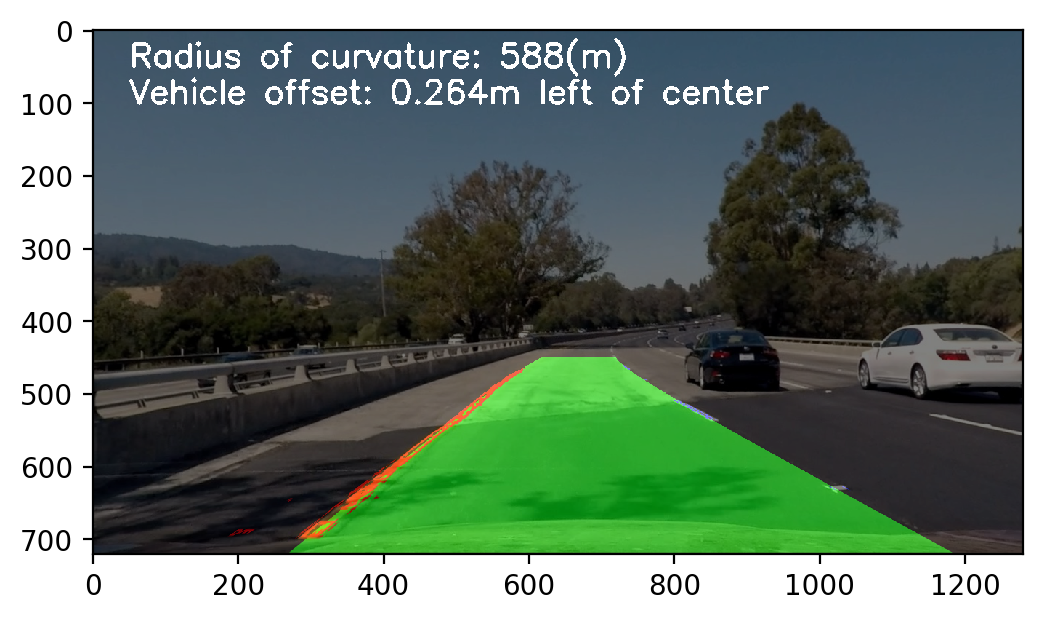

In [23]:
def detect_lane_boundaries(camera, persp, o_img, left_line, right_line):
    '''
    Takes camera obj, perspective obj, original image, left Line obj, right Line obj as input
    returns image with detected lane, lane curvature, and vehicle offset overlaid onto the image
    '''
    if not camera.is_calibrated():
        # Compute camera calibration if not done already
        camera.calibrate_camera()

    # Undistort o_img
    undist = camera.undistort(o_img)

    # Get birds-eye-view of highway image
    bev = persp.highway_birds_eye_view(undist)

    # Convert bev image to thresholded binary image
    bev_bin, _, _ = img2linebinary(bev)

    # Detect lines in this frame
    found, left_line, right_line = detect_lane_lines(bev_bin, left_line, right_line)
    if not found:
        # Lane could not be detected in this frame, overlay previous lanes onto this image
        print("Failed to detect lane in this frame, falling back to prev frame's lane estimate")

    # Determine real-world curvature of lanes (avg. of both lines' real curvature)
    left_lane_crv = left_line.compute_best_real_curvature(bev.shape)
    right_lane_crv = right_line.compute_best_real_curvature(bev.shape)
    if left_lane_crv and right_lane_crv:
        lane_curvature_s = "%d(m)" % int(round((left_lane_crv + right_lane_crv)/2))
    else:
        lane_curvature_s = "Not available"
        

    # Determine vehicle offset of center between lane line estimates (round to 3 decimal points)
    veh_offset = Line.compute_vehicle_lane_offset(left_line, right_line, bev.shape)
    if not veh_offset:
        veh_offset_s = "Not available"
    else:
        veh_offset_s = "%0.3fm" % np.abs(veh_offset)
        veh_offset_s += " left of center" if veh_offset > 0 else " right of center"
    
    # Visualization of lane area, detected lane pixels, curvature, and lane offset
    lane_area, _ = overlay_visualization(bev_bin, found, undist, persp, 
                                      left_line, right_line, lane_curvature_s, veh_offset_s)
    return lane_area

o_img = mpimg.imread("test_images/test4.jpg") 
camera = Camera()
persp = PerspectiveTransform()
left_line = Line()
right_line = Line()

result = detect_lane_boundaries(camera, persp, o_img, left_line, right_line)
plt.imshow(result)
plt.savefig("output_images/test4-visualization.jpg")

# Moving onto processing video

In [24]:
# Import everything needed to edit/save/watch video clips\n",
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Test on difficult subclip

In [25]:
# Wrap detect_lane_boundaries(...) in a 'partial' function to preserve state between video frames
camera = Camera()
persp = PerspectiveTransform()
left_line = Line()
right_line = Line()
def stateful_detect_lane_bounds(frame):
    return detect_lane_boundaries(camera, persp, frame, left_line, right_line)


white_output = 'test_output_video/project_video_labeled-middle.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(20,30)
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(stateful_detect_lane_bounds) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_output_video/project_video_labeled-middle.mp4
[MoviePy] Writing video test_output_video/project_video_labeled-middle.mp4


 14%|█▍        | 35/251 [00:04<00:25,  8.33it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 129.466889081
Curvatures 647.734081019 518.267191939
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 20%|██        | 51/251 [00:06<00:28,  7.00it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 112.581249187
Curvatures 631.350215034 743.931464221
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 114.603433353
Curvatures 641.357105206 755.960538558
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 21%|██        | 53/251 [00:06<00:28,  6.88it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 103.346067989
Curvatures 634.821278975 738.167346964
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 22%|██▏       | 55/251 [00:06<00:26,  7.30it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 105.935788361
Curvatures 638.463012147 744.398800508
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 24%|██▍       | 60/251 [00:07<00:27,  6.90it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 127.402279373
Curvatures 655.23193569 782.634215064
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 233.489134086
Curvatures 671.058357826 904.547491911
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 25%|██▍       | 62/251 [00:07<00:28,  6.65it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 277.234514401
Curvatures 677.112011865 954.346526265
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 309.852099844
Curvatures 685.094949665 994.947049508
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 25%|██▌       | 64/251 [00:08<00:27,  6.87it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 226.169232181
Curvatures 678.157536941 904.326769122
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 122.881876229
Curvatures 668.315480928 791.197357157
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 26%|██▋       | 66/251 [00:08<00:27,  6.64it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.567243399
Curvatures 701.31209084 803.879334239
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 30%|██▉       | 75/251 [00:09<00:24,  7.31it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 118.929503511
Curvatures 654.131103238 773.060606749
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 32%|███▏      | 81/251 [00:10<00:24,  6.88it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 151.28291182
Curvatures 648.54064778 497.25773596
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 145.517382548
Curvatures 650.67984236 505.162459812
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 33%|███▎      | 83/251 [00:10<00:24,  6.94it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 150.708619161
Curvatures 650.051124955 499.342505794
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 116.68853079
Curvatures 651.599301425 534.910770634
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 34%|███▍      | 86/251 [00:11<00:24,  6.82it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 107.848089742
Curvatures 647.933643715 540.085553973
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 211.534232668
Curvatures 645.465762672 433.931530003
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 35%|███▌      | 88/251 [00:11<00:22,  7.17it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 160.153030753
Curvatures 646.69772325 486.544692497
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 36%|███▌      | 90/251 [00:11<00:23,  6.72it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 539.200989445
Curvatures 717.116337685 1256.31732713
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 488.165674376
Curvatures 692.991457222 1181.1571316
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 37%|███▋      | 92/251 [00:12<00:24,  6.49it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 434.102932104
Curvatures 688.799592765 1122.90252487
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 264.973733902
Curvatures 664.401530347 929.375264249
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 38%|███▊      | 95/251 [00:12<00:21,  7.34it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 353.992724017
Curvatures 677.356070457 1031.34879447
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 128.686028435
Curvatures 654.555926779 783.241955215
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 39%|███▉      | 98/251 [00:13<00:21,  7.20it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 106.196758597
Curvatures 653.306634722 759.503393318
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 466.578125807
Curvatures 651.937030415 185.358904608
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 40%|███▉      | 100/251 [00:13<00:21,  7.18it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 224.167222713
Curvatures 660.222681865 884.389904578
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 207.147112076
Curvatures 666.592065678 873.739177754
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 41%|████      | 102/251 [00:13<00:22,  6.68it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 619.703125624
Curvatures 756.037058489 1375.74018411
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 604.788370191
Curvatures 745.129851854 1349.91822204
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 41%|████▏     | 104/251 [00:14<00:21,  6.82it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 835.754150024
Curvatures 738.402040063 1574.15619009
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 654.354590032
Curvatures 707.158909652 1361.51349968
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 42%|████▏     | 106/251 [00:14<00:21,  6.65it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1145.0620146
Curvatures 720.565950415 1865.62796502
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 740.413856219
Curvatures 683.983157546 1424.39701377
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 43%|████▎     | 108/251 [00:14<00:20,  7.09it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1004.2467141
Curvatures 675.898134961 1680.14484906
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 123.480877969
Curvatures 664.920835069 788.401713038
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 43%|████▎     | 109/251 [00:14<00:19,  7.13it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 203.606976137
Curvatures 659.730587632 863.33756377
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 499.296159469
Curvatures 657.196633227 157.900473758
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 45%|████▍     | 112/251 [00:15<00:20,  6.81it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 7278.49269803
Curvatures 669.302400053 7947.79509809
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 213153.674146
Curvatures 589.689387602 213743.363534
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 45%|████▌     | 114/251 [00:15<00:19,  6.94it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 683.674936753
Curvatures 783.645488049 99.9705512959
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 46%|████▌     | 116/251 [00:15<00:19,  6.81it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 678.608861945
Curvatures 710.175467156 31.5666052113
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 47%|████▋     | 118/251 [00:16<00:20,  6.62it/s]

Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 48%|████▊     | 120/251 [00:16<00:18,  6.93it/s]

Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 50%|████▉     | 125/251 [00:17<00:18,  6.87it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1016.3259736
Curvatures 652.59653175 1668.92250535
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 163.117935336
Curvatures 631.400211376 794.518146712
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 51%|█████     | 127/251 [00:17<00:17,  7.26it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 448.039716813
Curvatures 630.780973951 182.741257137
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 3576.0301122
Curvatures 621.910413439 4197.94052564
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 51%|█████▏    | 129/251 [00:17<00:17,  7.00it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 540.609095796
Curvatures 621.187590686 80.5784948895
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 485.239569234
Curvatures 761.853969276 1247.09353851
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 52%|█████▏    | 131/251 [00:17<00:16,  7.20it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 452.191190496
Curvatures 770.276441923 1222.46763242
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 494.637588436
Curvatures 727.707393988 1222.34498242
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 53%|█████▎    | 133/251 [00:18<00:16,  7.04it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1007.73156246
Curvatures 763.719457194 1771.45101965
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 1137.63880726
Curvatures 741.186700341 1878.8255076
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 54%|█████▍    | 135/251 [00:18<00:16,  7.20it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 280.506611453
Curvatures 665.332272848 945.838884302
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 311.881745003
Curvatures 659.697812423 971.579557426
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 55%|█████▍    | 137/251 [00:18<00:16,  7.12it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 162.464292112
Curvatures 642.10226386 479.637971748
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 572.082186763
Curvatures 630.251791406 58.169604643
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 55%|█████▌    | 139/251 [00:19<00:15,  7.12it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 272.029202138
Curvatures 630.426845387 358.39764325
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 189.135458546
Curvatures 632.422033668 443.286575122
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 56%|█████▌    | 141/251 [00:19<00:15,  6.93it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 116.545361044
Curvatures 638.948718274 522.40335723
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 373.543228985
Curvatures 644.608359688 271.065130703
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 57%|█████▋    | 144/251 [00:19<00:15,  6.84it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 131.041542651
Curvatures 628.122499145 497.080956494
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 62%|██████▏   | 156/251 [00:21<00:13,  7.20it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 450.653356828
Curvatures 552.47559554 101.822238711
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 71%|███████   | 178/251 [00:24<00:09,  7.57it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 142.914667225
Curvatures 623.962663873 481.047996647
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 80%|███████▉  | 200/251 [00:27<00:06,  7.30it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 113.054858942
Curvatures 612.894408995 499.839550053
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 148.760118774
Curvatures 610.672739719 461.912620945
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 80%|████████  | 202/251 [00:27<00:07,  6.76it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 187.470592147
Curvatures 609.436210389 421.965618242
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 218.206203833
Curvatures 609.697620487 391.491416654
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 81%|████████▏ | 204/251 [00:28<00:06,  6.78it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 238.398400593
Curvatures 612.526027054 374.127626461
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 138.032644353
Curvatures 626.714847399 488.682203046
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 82%|████████▏ | 206/251 [00:28<00:06,  7.30it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 204.159870341
Curvatures 613.24001416 409.080143819
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 135.748032121
Curvatures 624.150721326 488.402689205
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 83%|████████▎ | 208/251 [00:28<00:06,  7.08it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 140.208109868
Curvatures 626.465329616 486.257219748
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 91%|█████████ | 229/251 [00:31<00:03,  7.18it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 253.341910581
Curvatures 685.625847264 938.967757845
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 95%|█████████▌| 239/251 [00:32<00:01,  7.68it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 113.073666205
Curvatures 611.030899556 497.957233351
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


100%|█████████▉| 250/251 [00:34<00:00,  7.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output_video/project_video_labeled-middle.mp4 

CPU times: user 52.7 s, sys: 4.21 s, total: 56.9 s
Wall time: 36 s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Final project video

In [27]:
# Reset camera and lane line state for full video
camera = Camera()
persp = PerspectiveTransform()
left_line = Line()
right_line = Line()

white_output = 'test_output_video/project_video_full.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(stateful_detect_lane_bounds) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_output_video/project_video_full.mp4
[MoviePy] Writing video test_output_video/project_video_full.mp4


  2%|▏         | 23/1261 [00:03<02:21,  8.76it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 131.453067076
Curvatures 632.45594253 763.909009606
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 176.792883112
Curvatures 635.691425484 812.484308596
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  2%|▏         | 25/1261 [00:03<02:25,  8.52it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 212.559171086
Curvatures 635.982811321 848.541982407
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 242.056951806
Curvatures 634.991145701 877.048097507
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  2%|▏         | 29/1261 [00:03<02:27,  8.33it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 124.403711532
Curvatures 634.677234657 510.273523125
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  3%|▎         | 35/1261 [00:04<02:49,  7.23it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 365.775723861
Curvatures 712.291996303 1078.06772016
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  4%|▎         | 47/1261 [00:06<02:46,  7.27it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 105.130672085
Curvatures 648.828372627 753.959044712
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  4%|▍         | 49/1261 [00:06<02:54,  6.94it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.058725788
Curvatures 632.359780593 734.418506381
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 167.946257056
Curvatures 632.013284446 799.959541501
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  4%|▍         | 51/1261 [00:06<02:51,  7.06it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 127.04910986
Curvatures 628.771263563 755.820373423
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 179.11252152
Curvatures 629.567588764 808.680110284
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  5%|▍         | 59/1261 [00:07<02:46,  7.22it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 100.339703112
Curvatures 622.860412661 522.52070955
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  5%|▌         | 65/1261 [00:08<02:44,  7.25it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 107.898857139
Curvatures 622.23388841 514.335031271
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 102.159477452
Curvatures 621.796447552 519.6369701
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  5%|▌         | 68/1261 [00:09<02:48,  7.08it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 101.818442765
Curvatures 621.418967651 519.600524886
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  6%|▌         | 74/1261 [00:10<02:41,  7.36it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 146.016364659
Curvatures 635.967263739 781.983628398
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  6%|▌         | 78/1261 [00:10<02:45,  7.13it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 149.085227831
Curvatures 616.015227405 466.929999574
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  7%|▋         | 86/1261 [00:11<02:31,  7.75it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 104.037413349
Curvatures 654.769008185 758.806421535
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  7%|▋         | 90/1261 [00:12<02:46,  7.05it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 118.516595847
Curvatures 633.768621107 515.25202526
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 145.962273783
Curvatures 630.286305861 484.324032078
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  8%|▊         | 99/1261 [00:13<02:40,  7.26it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 203.156250056
Curvatures 642.427971928 845.584221984
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


  9%|▉         | 115/1261 [00:15<02:30,  7.61it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 265.692398021
Curvatures 641.99218411 907.684582132
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 10%|▉         | 125/1261 [00:17<02:33,  7.41it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 147.046022494
Curvatures 627.59053475 774.636557244
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 199.37531148
Curvatures 626.56397162 825.939283101
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 10%|█         | 128/1261 [00:17<02:35,  7.27it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 175.433165095
Curvatures 614.119296857 438.686131762
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 325.415861271
Curvatures 622.912228668 948.328089938
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 10%|█         | 130/1261 [00:17<02:38,  7.12it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 111.028685502
Curvatures 614.112737014 503.084051513
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 103.469147848
Curvatures 615.099772718 511.63062487
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 10%|█         | 132/1261 [00:18<02:38,  7.11it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 128.802898228
Curvatures 614.428068035 485.625169807
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 138.417741099
Curvatures 612.770779585 474.353038486
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 11%|█         | 134/1261 [00:18<02:33,  7.35it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 128.387644401
Curvatures 615.047707868 486.660063466
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 11%|█         | 136/1261 [00:18<02:31,  7.45it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 173.265382554
Curvatures 604.810787305 431.545404751
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 135.525225259
Curvatures 612.302863116 476.777637857
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 11%|█         | 141/1261 [00:19<02:34,  7.23it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 122.548395077
Curvatures 630.890949884 753.439344961
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 12%|█▏        | 149/1261 [00:20<02:32,  7.30it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 101.936309379
Curvatures 624.922823135 522.986513757
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 13%|█▎        | 159/1261 [00:21<02:39,  6.92it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 120.453659196
Curvatures 622.535179283 502.081520088
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 13%|█▎        | 165/1261 [00:22<02:39,  6.88it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.054531097
Curvatures 632.55161324 530.497082143
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 213.911889095
Curvatures 626.692885451 412.780996357
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 14%|█▍        | 174/1261 [00:23<02:16,  7.98it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 163.24332748
Curvatures 642.955819059 806.199146539
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 220.717765374
Curvatures 639.329466486 860.047231861
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 14%|█▍        | 176/1261 [00:24<02:32,  7.12it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 165.27330483
Curvatures 633.075766691 798.349071521
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 648.510205482
Curvatures 653.123430631 1301.63363611
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 14%|█▍        | 182/1261 [00:24<02:18,  7.79it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 109.88188652
Curvatures 639.955402157 530.073515637
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 147.447459619
Curvatures 643.306174508 495.858714888
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 15%|█▍        | 184/1261 [00:25<02:27,  7.32it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 138.802512153
Curvatures 644.580284792 505.777772639
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 15%|█▍        | 187/1261 [00:25<02:21,  7.60it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 139.735438462
Curvatures 645.071432977 505.335994515
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 139.095512107
Curvatures 644.626885306 505.531373199
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 15%|█▌        | 190/1261 [00:25<02:26,  7.31it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 253.882031373
Curvatures 636.064491747 382.182460374
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 231.058091292
Curvatures 634.510476509 403.452385217
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 15%|█▌        | 192/1261 [00:26<02:25,  7.37it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 225.349880652
Curvatures 631.623050548 406.273169895
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 173.383959008
Curvatures 631.85281014 458.468851132
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 15%|█▌        | 194/1261 [00:26<02:21,  7.53it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 197.165809391
Curvatures 628.369116064 431.203306673
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 186.374360476
Curvatures 625.925246111 439.550885635
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 16%|█▌        | 196/1261 [00:26<02:29,  7.14it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 140.647378926
Curvatures 625.937482709 485.290103783
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 146.894320817
Curvatures 618.652200147 471.75787933
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 16%|█▌        | 203/1261 [00:27<02:26,  7.22it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 394.373263164
Curvatures 652.871444769 1047.24470793
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 16%|█▋        | 208/1261 [00:28<02:30,  6.99it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 106.474460757
Curvatures 636.383417841 529.908957084
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 171.792906831
Curvatures 621.842944698 450.050037867
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 17%|█▋        | 210/1261 [00:28<02:20,  7.50it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 120.487438889
Curvatures 637.452872586 516.965433697
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 17%|█▋        | 216/1261 [00:29<02:27,  7.10it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 231.881596308
Curvatures 639.922477517 871.804073826
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 17%|█▋        | 220/1261 [00:30<02:32,  6.84it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 142.170843343
Curvatures 627.411382743 485.240539399
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 121.4905448
Curvatures 628.06122157 506.570676771
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 18%|█▊        | 222/1261 [00:30<02:25,  7.16it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 240.125425154
Curvatures 606.673206289 366.547781135
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 178.890748685
Curvatures 622.191985396 443.301236711
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 18%|█▊        | 224/1261 [00:30<02:29,  6.96it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 132.022364665
Curvatures 628.949749152 496.927384486
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 134.701619544
Curvatures 628.098503179 493.396883636
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 20%|█▉        | 246/1261 [00:33<02:14,  7.52it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 146.7463163
Curvatures 623.045327586 476.299011286
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 20%|█▉        | 250/1261 [00:34<02:15,  7.46it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 110.190613575
Curvatures 630.296404724 520.10579115
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 169.781323008
Curvatures 637.870683097 807.652006105
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 20%|██        | 256/1261 [00:35<02:18,  7.25it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.039566741
Curvatures 631.003557908 528.963991167
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 20%|██        | 258/1261 [00:35<02:16,  7.37it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 116.664940775
Curvatures 628.090803698 511.425862923
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 21%|██▏       | 270/1261 [00:37<02:15,  7.31it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 104.798591054
Curvatures 637.738672353 532.940081299
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 235.534882164
Curvatures 622.837661387 387.302779223
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 22%|██▏       | 273/1261 [00:37<02:10,  7.54it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 100.519469898
Curvatures 640.915913716 540.396443818
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 22%|██▏       | 281/1261 [00:38<02:07,  7.71it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 100.61636098
Curvatures 632.128610671 531.512249691
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 23%|██▎       | 294/1261 [00:40<02:12,  7.28it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 135.521738479
Curvatures 620.852761155 485.331022676
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 24%|██▍       | 305/1261 [00:41<02:07,  7.49it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 105.284873873
Curvatures 635.566377684 530.281503811
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 150.991860387
Curvatures 623.472234813 472.480374426
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 24%|██▍       | 307/1261 [00:41<02:05,  7.62it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 140.193264909
Curvatures 632.495082812 492.301817904
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 25%|██▍       | 311/1261 [00:42<02:06,  7.53it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 112.826844117
Curvatures 635.964434139 523.137590021
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 106.926210661
Curvatures 632.329261365 525.403050704
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 25%|██▍       | 313/1261 [00:42<02:09,  7.33it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 108.507642455
Curvatures 630.302151353 521.794508898
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 145.17636351
Curvatures 627.572475488 482.396111977
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 25%|██▍       | 315/1261 [00:43<02:10,  7.25it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 117.01894999
Curvatures 627.537900623 510.518950633
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 102.914679278
Curvatures 627.659726346 524.745047068
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 25%|██▌       | 320/1261 [00:43<02:04,  7.55it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 109.420549593
Curvatures 638.573368133 747.993917726
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 126.624951963
Curvatures 633.841295602 760.466247565
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 26%|██▌       | 329/1261 [00:44<01:58,  7.86it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 121.512838777
Curvatures 620.858677112 499.345838336
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 124.818706284
Curvatures 612.965483788 488.146777504
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 26%|██▋       | 333/1261 [00:45<02:08,  7.23it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 111.045987867
Curvatures 631.308979662 520.262991796
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 130.408433129
Curvatures 624.692566332 494.284133203
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 27%|██▋       | 335/1261 [00:45<02:11,  7.03it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 127.428349979
Curvatures 624.342417558 496.914067579
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 134.582437277
Curvatures 624.891650657 490.30921338
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 27%|██▋       | 343/1261 [00:46<02:11,  7.00it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.505223094
Curvatures 621.34566585 518.840442756
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 29%|██▉       | 366/1261 [00:50<02:06,  7.06it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 379.931556541
Curvatures 700.482564476 1080.41412102
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 29%|██▉       | 370/1261 [00:50<01:59,  7.43it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 110.925003827
Curvatures 619.697136162 508.772132335
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 131.779861976
Curvatures 616.602915092 484.823053116
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 30%|██▉       | 372/1261 [00:50<02:01,  7.30it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 144.810052461
Curvatures 618.767091164 473.957038704
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 125.103156308
Curvatures 621.043648758 495.940492451
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 30%|██▉       | 374/1261 [00:51<01:58,  7.50it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 106.880106359
Curvatures 624.622684095 517.742577736
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 102.576252526
Curvatures 627.733932719 525.157680193
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 30%|██▉       | 377/1261 [00:51<01:55,  7.67it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 137.897389058
Curvatures 628.754968318 490.85757926
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 126.707513425
Curvatures 628.632123265 501.92460984
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 30%|███       | 379/1261 [00:51<01:59,  7.36it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 120.912459896
Curvatures 632.024227875 511.111767978
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 36%|███▌      | 457/1261 [01:02<01:50,  7.26it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 100.038250452
Curvatures 635.621166203 535.582915751
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 42%|████▏     | 535/1261 [01:13<01:43,  7.02it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 129.466889081
Curvatures 647.734081019 518.267191939
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 44%|████▎     | 551/1261 [01:15<01:45,  6.71it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 112.581249187
Curvatures 631.350215034 743.931464221
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 115.081876515
Curvatures 641.784061573 756.865938088
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 44%|████▍     | 553/1261 [01:16<01:41,  6.98it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 103.346067989
Curvatures 634.821278975 738.167346964
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 44%|████▍     | 555/1261 [01:16<01:36,  7.31it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 105.935788361
Curvatures 638.463012147 744.398800508
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 44%|████▍     | 560/1261 [01:17<01:41,  6.90it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 127.402279373
Curvatures 655.23193569 782.634215064
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 233.489134086
Curvatures 671.058357826 904.547491911
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 45%|████▍     | 562/1261 [01:17<01:45,  6.61it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 277.234514401
Curvatures 677.112011865 954.346526265
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 309.852099844
Curvatures 685.094949665 994.947049508
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 45%|████▍     | 564/1261 [01:17<01:39,  6.97it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 226.169232181
Curvatures 678.157536941 904.326769122
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 122.881876229
Curvatures 668.315480928 791.197357157
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 45%|████▍     | 566/1261 [01:17<01:43,  6.71it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.567243399
Curvatures 701.31209084 803.879334239
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 46%|████▌     | 575/1261 [01:19<01:36,  7.08it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 118.929503511
Curvatures 654.131103238 773.060606749
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 46%|████▌     | 581/1261 [01:20<01:38,  6.89it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 151.28291182
Curvatures 648.54064778 497.25773596
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 145.517382548
Curvatures 650.67984236 505.162459812
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 46%|████▌     | 583/1261 [01:20<01:39,  6.83it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 150.708619161
Curvatures 650.051124955 499.342505794
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 116.68853079
Curvatures 651.599301425 534.910770634
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 46%|████▋     | 586/1261 [01:20<01:39,  6.77it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 107.848089742
Curvatures 647.933643715 540.085553973
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 211.534232668
Curvatures 645.465762672 433.931530003
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 47%|████▋     | 588/1261 [01:21<01:38,  6.85it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 160.153030753
Curvatures 646.69772325 486.544692497
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 47%|████▋     | 590/1261 [01:21<01:39,  6.73it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 539.200989445
Curvatures 717.116337685 1256.31732713
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 488.165674376
Curvatures 692.991457222 1181.1571316
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 47%|████▋     | 592/1261 [01:21<01:38,  6.79it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 434.102932104
Curvatures 688.799592765 1122.90252487
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 264.973733902
Curvatures 664.401530347 929.375264249
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 47%|████▋     | 595/1261 [01:22<01:34,  7.01it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 353.992724017
Curvatures 677.356070457 1031.34879447
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 128.686028435
Curvatures 654.555926779 783.241955215
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 47%|████▋     | 598/1261 [01:22<01:36,  6.88it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 106.196758597
Curvatures 653.306634722 759.503393318
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 466.578125807
Curvatures 651.937030415 185.358904608
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 48%|████▊     | 600/1261 [01:22<01:36,  6.84it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 224.167222713
Curvatures 660.222681865 884.389904578
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 207.147112076
Curvatures 666.592065678 873.739177754
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 48%|████▊     | 602/1261 [01:23<01:34,  6.99it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 619.703125624
Curvatures 756.037058489 1375.74018411
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 604.788370191
Curvatures 745.129851854 1349.91822204
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 48%|████▊     | 604/1261 [01:23<01:34,  6.97it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 835.754150024
Curvatures 738.402040063 1574.15619009
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 654.354590032
Curvatures 707.158909652 1361.51349968
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 48%|████▊     | 606/1261 [01:23<01:32,  7.11it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1145.0620146
Curvatures 720.565950415 1865.62796502
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 740.413856219
Curvatures 683.983157546 1424.39701377
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 48%|████▊     | 608/1261 [01:24<01:35,  6.84it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1004.2467141
Curvatures 675.898134961 1680.14484906
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 123.480877969
Curvatures 664.920835069 788.401713038
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 48%|████▊     | 610/1261 [01:24<01:37,  6.65it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 203.606976137
Curvatures 659.730587632 863.33756377
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 499.296159469
Curvatures 657.196633227 157.900473758
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 49%|████▊     | 612/1261 [01:24<01:36,  6.73it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 7278.49269803
Curvatures 669.302400053 7947.79509809
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 213153.674146
Curvatures 589.689387602 213743.363534
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 49%|████▊     | 614/1261 [01:24<01:36,  6.74it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 683.674936753
Curvatures 783.645488049 99.9705512959
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 49%|████▉     | 616/1261 [01:25<01:31,  7.06it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 678.608861945
Curvatures 710.175467156 31.5666052113
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 49%|████▉     | 618/1261 [01:25<01:30,  7.12it/s]

Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 49%|████▉     | 620/1261 [01:25<01:26,  7.44it/s]

Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Caught exception! Skipping bad frame due to: need at least one array to concatenate
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 50%|████▉     | 625/1261 [01:26<01:30,  7.02it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1016.3259736
Curvatures 652.59653175 1668.92250535
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 163.117935336
Curvatures 631.400211376 794.518146712
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 50%|████▉     | 627/1261 [01:26<01:26,  7.35it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 448.039716813
Curvatures 630.780973951 182.741257137
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 3576.0301122
Curvatures 621.910413439 4197.94052564
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 50%|████▉     | 629/1261 [01:26<01:27,  7.26it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 540.609095796
Curvatures 621.187590686 80.5784948895
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 485.239569234
Curvatures 761.853969276 1247.09353851
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 50%|█████     | 631/1261 [01:27<01:32,  6.84it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 452.191190496
Curvatures 770.276441923 1222.46763242
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 494.637588436
Curvatures 727.707393988 1222.34498242
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 50%|█████     | 633/1261 [01:27<01:30,  6.96it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1007.73156246
Curvatures 763.719457194 1771.45101965
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 1137.63880726
Curvatures 741.186700341 1878.8255076
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 50%|█████     | 635/1261 [01:27<01:31,  6.84it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 280.506611453
Curvatures 665.332272848 945.838884302
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 311.881745003
Curvatures 659.697812423 971.579557426
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 51%|█████     | 637/1261 [01:28<01:38,  6.33it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 162.464292112
Curvatures 642.10226386 479.637971748
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 572.082186763
Curvatures 630.251791406 58.169604643
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 51%|█████     | 639/1261 [01:28<01:31,  6.81it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 272.029202138
Curvatures 630.426845387 358.39764325
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 189.135458546
Curvatures 632.422033668 443.286575122
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 51%|█████     | 641/1261 [01:28<01:34,  6.59it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 116.545361044
Curvatures 638.948718274 522.40335723
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 373.543228985
Curvatures 644.608359688 271.065130703
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 51%|█████     | 644/1261 [01:29<01:25,  7.26it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 131.041542651
Curvatures 628.122499145 497.080956494
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 52%|█████▏    | 656/1261 [01:30<01:26,  6.99it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 450.653356828
Curvatures 552.47559554 101.822238711
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 54%|█████▍    | 678/1261 [01:33<01:19,  7.31it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 142.914667225
Curvatures 623.962663873 481.047996647
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 56%|█████▌    | 700/1261 [01:37<01:16,  7.30it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 113.054858942
Curvatures 612.894408995 499.839550053
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 148.760118774
Curvatures 610.672739719 461.912620945
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 56%|█████▌    | 702/1261 [01:37<01:15,  7.39it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 187.470592147
Curvatures 609.436210389 421.965618242
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 218.206203833
Curvatures 609.697620487 391.491416654
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 56%|█████▌    | 704/1261 [01:37<01:16,  7.32it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 238.398400593
Curvatures 612.526027054 374.127626461
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 138.032644353
Curvatures 626.714847399 488.682203046
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 56%|█████▌    | 706/1261 [01:37<01:19,  6.96it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 204.159870341
Curvatures 613.24001416 409.080143819
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 135.748032121
Curvatures 624.150721326 488.402689205
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 56%|█████▌    | 708/1261 [01:38<01:20,  6.89it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 140.208109868
Curvatures 626.465329616 486.257219748
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 58%|█████▊    | 729/1261 [01:41<01:16,  6.94it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 253.341910581
Curvatures 685.625847264 938.967757845
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 59%|█████▊    | 739/1261 [01:42<01:10,  7.37it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 113.073666205
Curvatures 611.030899556 497.957233351
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 61%|██████    | 764/1261 [01:45<01:06,  7.49it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 130.144845231
Curvatures 611.48823896 741.633084191
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 476.056371261
Curvatures 681.922103117 1157.97847438
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 61%|██████    | 766/1261 [01:46<01:08,  7.23it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 539.611708965
Curvatures 796.603455411 256.991746446
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 151.630156724
Curvatures 622.747223343 774.377380067
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 62%|██████▏   | 777/1261 [01:47<01:03,  7.62it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 252.773508674
Curvatures 671.661611324 924.435119998
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 253.486034456
Curvatures 649.98301919 903.469053645
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 62%|██████▏   | 779/1261 [01:47<01:04,  7.47it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 380.893389196
Curvatures 656.677564879 1037.57095407
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 208.709744475
Curvatures 640.82246266 849.532207134
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 62%|██████▏   | 781/1261 [01:48<01:09,  6.94it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1201.59565596
Curvatures 690.072048146 1891.66770411
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 64%|██████▍   | 804/1261 [01:51<01:00,  7.58it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 152.260313558
Curvatures 629.053092164 781.313405722
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 65%|██████▍   | 818/1261 [01:53<01:00,  7.37it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 150.951602723
Curvatures 616.227850434 465.276247711
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 154.047543009
Curvatures 618.062105883 464.014562873
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 65%|██████▌   | 820/1261 [01:53<00:56,  7.85it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 107.276686278
Curvatures 621.498771144 514.222084866
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 69%|██████▉   | 868/1261 [01:59<00:56,  6.95it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 117.178097955
Curvatures 642.903040961 760.081138916
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 120.089108798
Curvatures 641.582848369 761.671957167
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 69%|██████▉   | 870/1261 [02:00<00:56,  6.93it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 104.861008757
Curvatures 640.607589065 745.468597823
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 111.875500312
Curvatures 642.275887081 754.151387394
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 69%|██████▉   | 872/1261 [02:00<00:53,  7.24it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 105.842413299
Curvatures 643.079149369 748.921562668
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 128.086996758
Curvatures 646.670084398 774.757081156
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 69%|██████▉   | 874/1261 [02:00<00:53,  7.25it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 127.516365883
Curvatures 642.771951826 770.288317709
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 141.523874221
Curvatures 644.019920659 785.54379488
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 69%|██████▉   | 876/1261 [02:00<00:52,  7.38it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 138.761329219
Curvatures 640.672772074 779.434101292
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 114.074342453
Curvatures 637.412465267 751.48680772
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 70%|██████▉   | 878/1261 [02:01<00:55,  6.90it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 121.924705326
Curvatures 637.844670056 759.769375382
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 128.157583502
Curvatures 638.968098821 767.125682323
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 71%|███████   | 893/1261 [02:03<00:49,  7.42it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 149.630646123
Curvatures 648.846350518 798.476996641
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 72%|███████▏  | 906/1261 [02:05<00:45,  7.76it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 107.450251567
Curvatures 635.097379614 742.547631182
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 105.690715251
Curvatures 643.946155173 749.636870424
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 72%|███████▏  | 908/1261 [02:05<00:48,  7.32it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 120.670394084
Curvatures 643.455706841 764.126100924
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 109.792366849
Curvatures 639.601847532 749.394214381
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 72%|███████▏  | 910/1261 [02:05<00:46,  7.52it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.682354321
Curvatures 635.750478098 738.432832419
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 78%|███████▊  | 987/1261 [02:16<00:38,  7.16it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 118.912310837
Curvatures 636.446990485 755.359301322
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 116.560906782
Curvatures 635.12210486 751.683011642
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 79%|███████▊  | 990/1261 [02:16<00:39,  6.93it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 123.130405942
Curvatures 651.203127946 774.333533888
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 152.850823874
Curvatures 607.277592369 760.128416243
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 79%|███████▊  | 992/1261 [02:16<00:36,  7.33it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 115.133790191
Curvatures 651.674604624 766.808394815
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 113.280421813
Curvatures 646.51466189 759.795083703
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 79%|███████▉  | 994/1261 [02:16<00:37,  7.13it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 112.628469195
Curvatures 633.951177255 746.57964645
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 80%|███████▉  | 1004/1261 [02:18<00:36,  7.14it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 162.898036108
Curvatures 683.865623507 846.763659615
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 199.891605295
Curvatures 708.480784537 908.372389832
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 80%|███████▉  | 1006/1261 [02:18<00:35,  7.25it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 199.174970028
Curvatures 702.968987816 902.143957844
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 80%|███████▉  | 1008/1261 [02:18<00:36,  6.99it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 115.902086461
Curvatures 681.181382466 797.083468927
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 80%|████████  | 1013/1261 [02:19<00:36,  6.85it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 187.5657369
Curvatures 671.138452025 858.704188924
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 165.526811842
Curvatures 670.074521061 835.601332903
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 80%|████████  | 1015/1261 [02:20<00:37,  6.51it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 169.835167027
Curvatures 668.537349105 838.372516131
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 182.290445565
Curvatures 665.070748167 847.361193731
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 81%|████████  | 1017/1261 [02:20<00:35,  6.83it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 136.289528858
Curvatures 674.304545417 810.594074275
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 133.190799298
Curvatures 669.058496868 802.249296166
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 81%|████████  | 1022/1261 [02:21<00:35,  6.71it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.206122075
Curvatures 659.28471848 761.490840555
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 177.926342307
Curvatures 664.925689139 842.852031447
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 81%|████████  | 1024/1261 [02:21<00:34,  6.91it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 175.977403815
Curvatures 675.433188803 851.410592618
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 223.831902871
Curvatures 685.074163887 908.906066758
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 81%|████████▏ | 1026/1261 [02:21<00:34,  6.73it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 244.818508983
Curvatures 683.410864148 928.229373132
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 82%|████████▏ | 1031/1261 [02:22<00:33,  6.84it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 152.261755922
Curvatures 667.296337576 515.034581654
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 514.94721324
Curvatures 615.059991663 100.112778423
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 82%|████████▏ | 1033/1261 [02:22<00:34,  6.70it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 590.832309674
Curvatures 619.353367959 28.521058285
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 416.209725339
Curvatures 746.485654948 1162.69538029
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 82%|████████▏ | 1035/1261 [02:22<00:31,  7.21it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 638.15487885
Curvatures 650.401245541 12.2463666902
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: estimated real lane width above threshold: 10.7964625598
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 82%|████████▏ | 1037/1261 [02:23<00:31,  7.05it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 1461.88959645
Curvatures 1628.95691804 3090.84651449
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 398.354219044
Curvatures 968.658856139 1367.01307518
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 82%|████████▏ | 1039/1261 [02:23<00:35,  6.30it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 121.134550692
Curvatures 678.28564557 557.151094878
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 775.844654121
Curvatures 281.679383706 1057.52403783
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 83%|████████▎ | 1041/1261 [02:23<00:33,  6.57it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 286.379400152
Curvatures 510.580232476 224.200832324
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 130.742548298
Curvatures 509.26556933 378.523021032
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 83%|████████▎ | 1043/1261 [02:24<00:34,  6.34it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 428.118790993
Curvatures 636.039042541 1064.15783353
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 191.165818263
Curvatures 498.48766145 689.653479713
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 83%|████████▎ | 1046/1261 [02:24<00:33,  6.49it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 146.245142989
Curvatures 553.144695005 699.389837993
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 139.013134801
Curvatures 591.129948917 730.143083718
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 83%|████████▎ | 1048/1261 [02:24<00:30,  6.97it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 202.342866178
Curvatures 599.327855977 801.670722154
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 3879.72281727
Curvatures 398.404117193 4278.12693446
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 83%|████████▎ | 1050/1261 [02:25<00:29,  7.24it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 12451.1938665
Curvatures 420.124190544 12871.3180571
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 1913.32673084
Curvatures 724.239868209 2637.56659905
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 83%|████████▎ | 1052/1261 [02:25<00:28,  7.26it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 2376.51959708
Curvatures 706.361571059 3082.88116814
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 84%|████████▎ | 1055/1261 [02:25<00:29,  7.06it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 131.71492168
Curvatures 602.68264115 470.96771947
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 85%|████████▌ | 1074/1261 [02:28<00:28,  6.61it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 108.848864319
Curvatures 649.127085291 757.97594961
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 121.902908884
Curvatures 650.782493957 772.68540284
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 85%|████████▌ | 1076/1261 [02:28<00:27,  6.69it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 128.309462674
Curvatures 649.124600294 777.434062968
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 145.373190604
Curvatures 645.228534545 790.601725149
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 85%|████████▌ | 1078/1261 [02:29<00:26,  6.78it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 102.049203628
Curvatures 634.925370472 736.974574099
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 86%|████████▌ | 1087/1261 [02:30<00:24,  7.10it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 108.996701056
Curvatures 645.290893345 754.287594401
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 87%|████████▋ | 1103/1261 [02:32<00:22,  7.13it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 108.93404759
Curvatures 632.519908062 741.453955652
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 101.336329232
Curvatures 632.539116359 733.875445591
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 88%|████████▊ | 1105/1261 [02:33<00:22,  7.07it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 103.081114691
Curvatures 631.055375529 734.13649022
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 89%|████████▊ | 1116/1261 [02:34<00:19,  7.63it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 105.812602086
Curvatures 634.896189029 740.708791115
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 89%|████████▉ | 1120/1261 [02:35<00:18,  7.57it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 112.499954144
Curvatures 628.298067066 740.798021209
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 135.147478934
Curvatures 628.882004897 764.029483831
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 89%|████████▉ | 1122/1261 [02:35<00:19,  7.24it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 155.931208196
Curvatures 627.908302306 783.839510501
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 185.422023438
Curvatures 631.590110031 817.012133469
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 89%|████████▉ | 1124/1261 [02:35<00:18,  7.31it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 194.450224817
Curvatures 628.049706789 822.499931606
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 176.140862
Curvatures 622.862183738 799.003045739
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 89%|████████▉ | 1126/1261 [02:35<00:17,  7.66it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 189.528431304
Curvatures 623.196474027 812.724905332
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 183.428885226
Curvatures 623.455048591 806.883933817
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 89%|████████▉ | 1128/1261 [02:36<00:18,  7.27it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 140.28393125
Curvatures 621.064601635 761.348532885
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 146.310502585
Curvatures 624.298791075 770.609293661
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 90%|████████▉ | 1130/1261 [02:36<00:18,  7.21it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 112.296234766
Curvatures 627.316773518 739.613008284
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 92%|█████████▏| 1155/1261 [02:39<00:14,  7.36it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 125.129048451
Curvatures 633.773457371 758.902505823
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 116.006830002
Curvatures 630.293488626 746.300318628
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 92%|█████████▏| 1157/1261 [02:40<00:14,  6.97it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 116.199715962
Curvatures 625.424463007 741.624178969
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 149.605506197
Curvatures 632.995600506 782.601106703
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 92%|█████████▏| 1159/1261 [02:40<00:14,  7.10it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 130.2352759
Curvatures 632.271449724 762.506725625
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 131.545817003
Curvatures 632.672706897 764.2185239
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 92%|█████████▏| 1161/1261 [02:40<00:14,  6.86it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 104.195326753
Curvatures 630.634029049 734.829355802
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 94%|█████████▎| 1182/1261 [02:43<00:12,  6.45it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 104.136829693
Curvatures 630.174714573 734.311544265
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 94%|█████████▍| 1184/1261 [02:44<00:12,  6.17it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 108.658343174
Curvatures 627.724368605 736.38271178
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 94%|█████████▍| 1187/1261 [02:44<00:10,  6.85it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 104.158683417
Curvatures 647.227242855 751.385926272
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 104.538448488
Curvatures 638.822912236 743.361360724
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 94%|█████████▍| 1189/1261 [02:44<00:10,  7.17it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 107.79598908
Curvatures 636.828082668 744.624071748
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 126.820625354
Curvatures 637.624283826 764.444909181
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 94%|█████████▍| 1191/1261 [02:45<00:10,  6.98it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 117.080182248
Curvatures 633.124067939 750.204250186
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 122.940932298
Curvatures 630.062638373 753.003570671
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 95%|█████████▌| 1201/1261 [02:46<00:08,  6.95it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 123.130636721
Curvatures 639.033444157 762.164080878
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 95%|█████████▌| 1203/1261 [02:46<00:08,  6.99it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 110.029238982
Curvatures 642.001943786 752.031182768
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 97%|█████████▋| 1228/1261 [02:50<00:04,  7.18it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 109.371656713
Curvatures 625.633463969 735.005120682
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 152.054231127
Curvatures 627.585774673 779.6400058
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 98%|█████████▊| 1230/1261 [02:50<00:04,  7.03it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 191.92168022
Curvatures 630.91174936 822.83342958
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 164.979476387
Curvatures 633.623245618 798.602722005
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 98%|█████████▊| 1232/1261 [02:50<00:04,  7.02it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 129.118459338
Curvatures 629.73958632 758.858045658
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 139.287808338
Curvatures 636.782301192 776.07010953
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 98%|█████████▊| 1234/1261 [02:50<00:03,  7.21it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 122.796126575
Curvatures 632.278382475 755.07450905
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 129.387605573
Curvatures 632.778001445 762.165607017
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


 98%|█████████▊| 1238/1261 [02:51<00:03,  7.23it/s]

Sanity failure: lines not roughly parallel. (bot-top) difference: 111.704518296
Curvatures 623.821249214 735.52576751
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate
Sanity failure: lines not roughly parallel. (bot-top) difference: 106.902206937
Curvatures 627.076854342 733.979061279
Prepared to reset!
Prepared to reset!
Failed to detect lane in this frame, falling back to prev frame's lane estimate


100%|█████████▉| 1260/1261 [02:54<00:00,  7.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output_video/project_video_full.mp4 

CPU times: user 4min 26s, sys: 19.3 s, total: 4min 46s
Wall time: 2min 56s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
